In [1]:
import sys
import time
import os
from collections import defaultdict
import numpy as np
import jax.numpy as jnp
import vedo
from vedo import Volume, show
import vedo.plotter  # https://vedo.embl.es/docs/vedo/plotter.html#Plotter
from vedo.colors import color_map
vedo.settings.default_backend = "vtk"
# vedo.settings.renderer_frame_width = 1.
# vedo.settings.use_parallel_projection = True

import matplotlib.pyplot as plt
# from matplotlib import colormaps
# list(colormaps)
from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import interact

from jax import jit, vmap, value_and_grad, nn
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft2, ifft2, fftshift, fftfreq
from jaxdf import FourierSeries 
from jaxdf.operators import compose
from jwave.geometry import Domain, Medium, TimeAxis, circ_mask
from jwave.acoustics import simulate_wave_propagation

from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage
import vis
import reconstruct as r
import generate_data as gd
import util as u
import reconstruct as r
from PADataset import PADataset
from flax import linen as nn

dataset=PADataset(path="data_setup/")
data = dataset[0]
mu = data['mu']
c = data['c']
sensors = data['sensors']
ATT_masks = data['ATT_masks']
P_0 = data['P_0']
P_data = data['P_data']
angles = data['angles']
P_data_noisy = data['P_data_noisy']


2024-08-17 23:33:10.614491: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-08-17 23:33:10.614612: E external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:252] kernel version 550.100.0 does not match DSO version 550.107.2 -- cannot find working devices in this configuration


RuntimeError: Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices. (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

In [ ]:
dataset.path

'data_illum_nn/'

## Volume

In [3]:
save_path = '../../Report/figures/'

# generate
vessels = gd.generate_vessels_3d(u.N, shrink_factor=1)
# np.save(save_path+"vessels", vessels[0])

# Volume(np.load(save_path+"vessels.npy", allow_pickle=True)).show(mode=6,resetcam=True, axes=6)

Volume(np.load(save_path+"vessels.npy")).show(screenshot=save_path+"vessels_3d", size=(800, 800), axes=6, elevation=15, azimuth=15, zoom=1.2)

## Setup
### mu

NameError: name 'save_path' is not defined

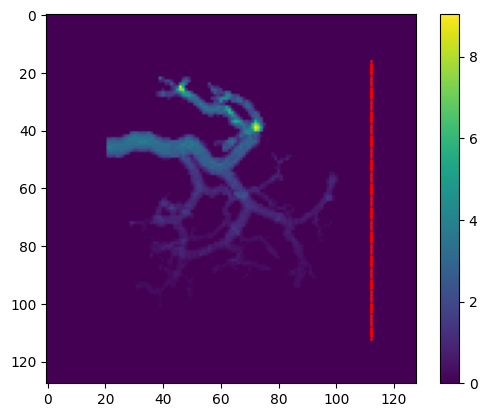

In [3]:
plt.figure()
plt.imshow(mu, aspect="equal")
plt.scatter(sensors[1], sensors[0], c="r", s=1)
# plt.title(r"$\boldsymbol{\mu}$ and sensor array")
plt.colorbar(plt.imshow(P_0[0]))
plt.savefig(save_path + "setup_2d.pdf", format='pdf', bbox_inches="tight")

### c

NameError: name 'save_path' is not defined

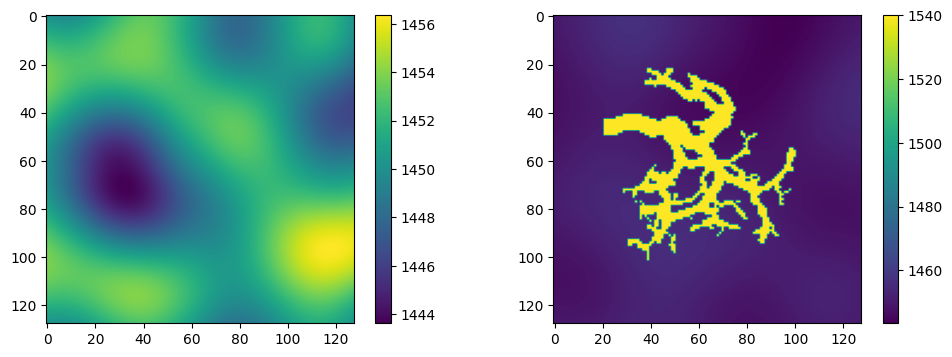

In [4]:

noise = gd.generate_perlin_noise_2d(
    u.N[:2],
    [u.C_PERIODICITY] * 2,
    tileable=(False, False),
)*u.C_VARIATION_AMPLITUDE +u.C


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
im1 = ax[0].imshow(noise)
im2 = ax[1].imshow(c)

# Create colorbars for each axis
cbar1 = fig.colorbar(im1, ax=ax[0])
cbar2 = fig.colorbar(im2, ax=ax[1])

plt.savefig(save_path + "c.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# def plot_att_masks_p0_pdata(ATT_masks, P_0, P_data, angles, save_path):
#     num = len(angles)
#     fig, ax = create_figure_with_gridspec(3, num, width=1.5, height=8, height_ratios=[1, 1, 2])

#     # Compute global min and max for color scales
#     min_max_a = compute_min_max([ATT_masks])
#     min_max_p = compute_min_max([P_0])
#     min_max_d = compute_min_max([P_data])

#     # Plot ATT_masks, P_0, and P_data
#     plot_images(ax[0], ATT_masks, min_max_a, titles=[fr"{angle:.0f}$\degree$" for angle in angles])
#     plot_images(ax[1], P_0, min_max_p)
#     plot_images(ax[2], P_data, min_max_d, aspect="auto")

#     # Add colorbars
#     add_colorbar(fig, ax[0], ax[0])
#     add_colorbar(fig, ax[1], ax[1])
#     add_colorbar(fig, ax[2], ax[2])

#     plt.savefig(save_path + "att_masks_p0_pdata.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

# plot_att_masks_p0_pdata(ATT_masks, P_0, P_data, angles, save_path)

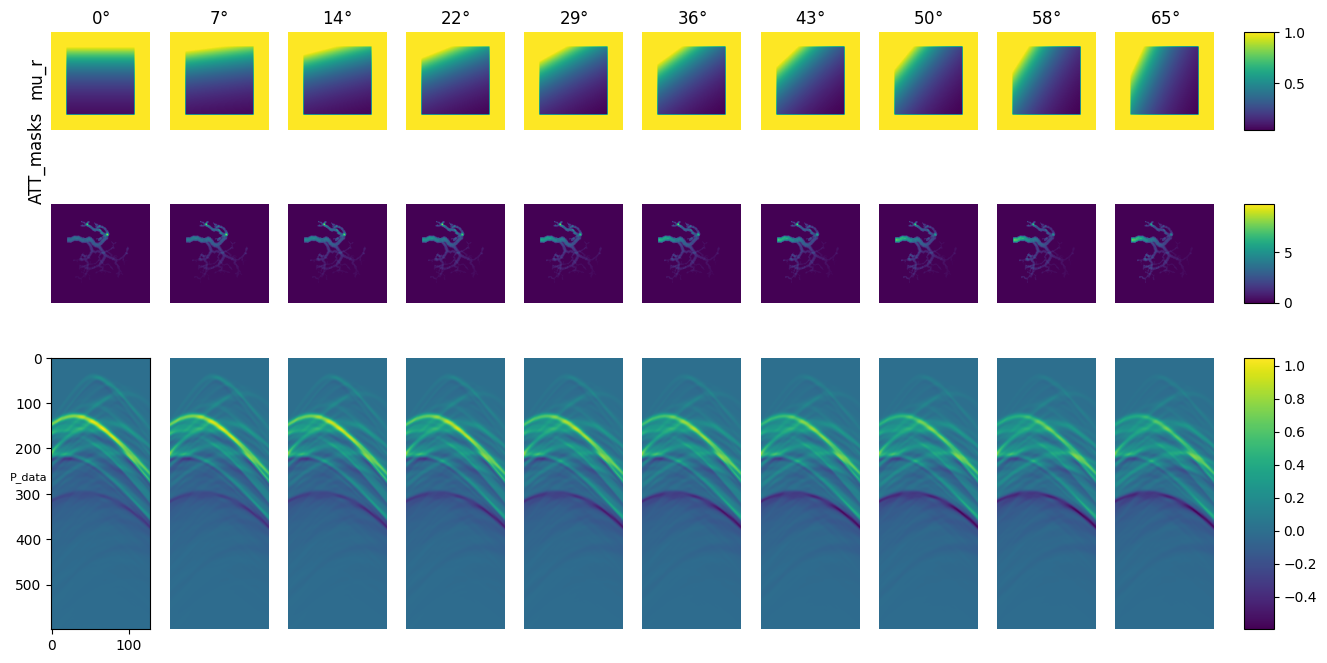

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
dpi = 500
save_path = '../../Report/figures/'
num = 10
# num = u.NUM_LIGHTING_ANGLES
fig = plt.figure(figsize=(num * 1.5, 8))
gs = gridspec.GridSpec(3, num, height_ratios=[1, 1, 2])

ax = [[fig.add_subplot(gs[i, j]) for j in range(num)] for i in range(3)]

# Store min and max for colorbars
min_max_a = [np.min(ATT_masks), np.max(ATT_masks)]
min_max_p = [np.min(P_0), np.max(P_0)]
min_max_d = [np.min(P_data), np.max(P_data)]

for i in range(num):
    im_a = ax[0][i].imshow(ATT_masks[i], aspect="equal", vmin=min_max_a[0], vmax=min_max_a[1])
    ax[0][i].set_title(fr"{angles[i]:.0f}$\degree$")
    ax[0][i].axis("off")
    ax[1][i].axis("off")
    im_p = ax[1][i].imshow(P_0[i], aspect="equal", vmin=min_max_p[0], vmax=min_max_p[1])
    im_d = ax[2][i].imshow(P_data[i], aspect="auto", vmin=min_max_d[0], vmax=min_max_d[1])
    if i > 0:
        ax[2][i].axis("off")

for row in range(3):
    # Get the positions of the first and last subplot in each row
    bottom = ax[row][0].get_position().y0
    top = ax[row][0].get_position().y1
    center_y = (top + bottom) / 2
    height = top - bottom

    # Create an axes for the colorbar
    cbar_ax = fig.add_axes([0.92, center_y - height / 2, 0.02, height])
    plt.colorbar(ax[row][0].images[0], cax=cbar_ax)

fig.text(0.115, 0.7, 'ATT_masks', va='center', ha='center', rotation='vertical', fontsize=12)
fig.text(0.115, 0.8, 'mu_r', va='center', ha='center', rotation='vertical', fontsize=12)
fig.text(0.11, 0.3, 'P_data', va='center', ha='center', fontsize=8)

# plt.savefig(save_path + "att_masks_p0_pdata.pdf", format="pdf", bbox_inches="tight", dpi=dpi)
plt.show()


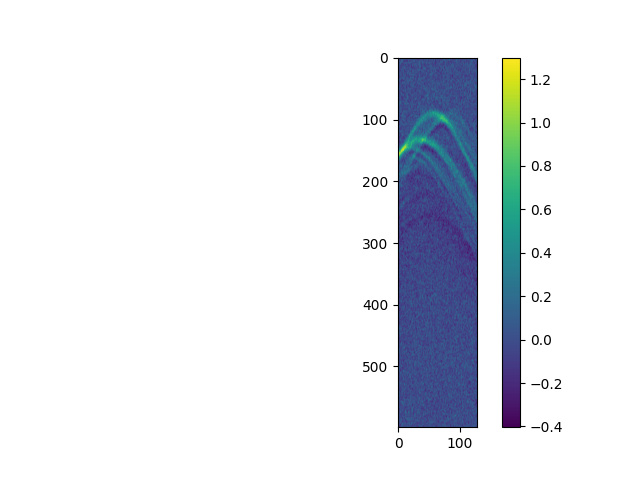

In [ ]:
plt.figure()
plt.imshow(P_data_noisy[0])
plt.colorbar()
plt.savefig(save_path+"P_data_noisy.pdf", format="pdf", bbox_inches="tight")

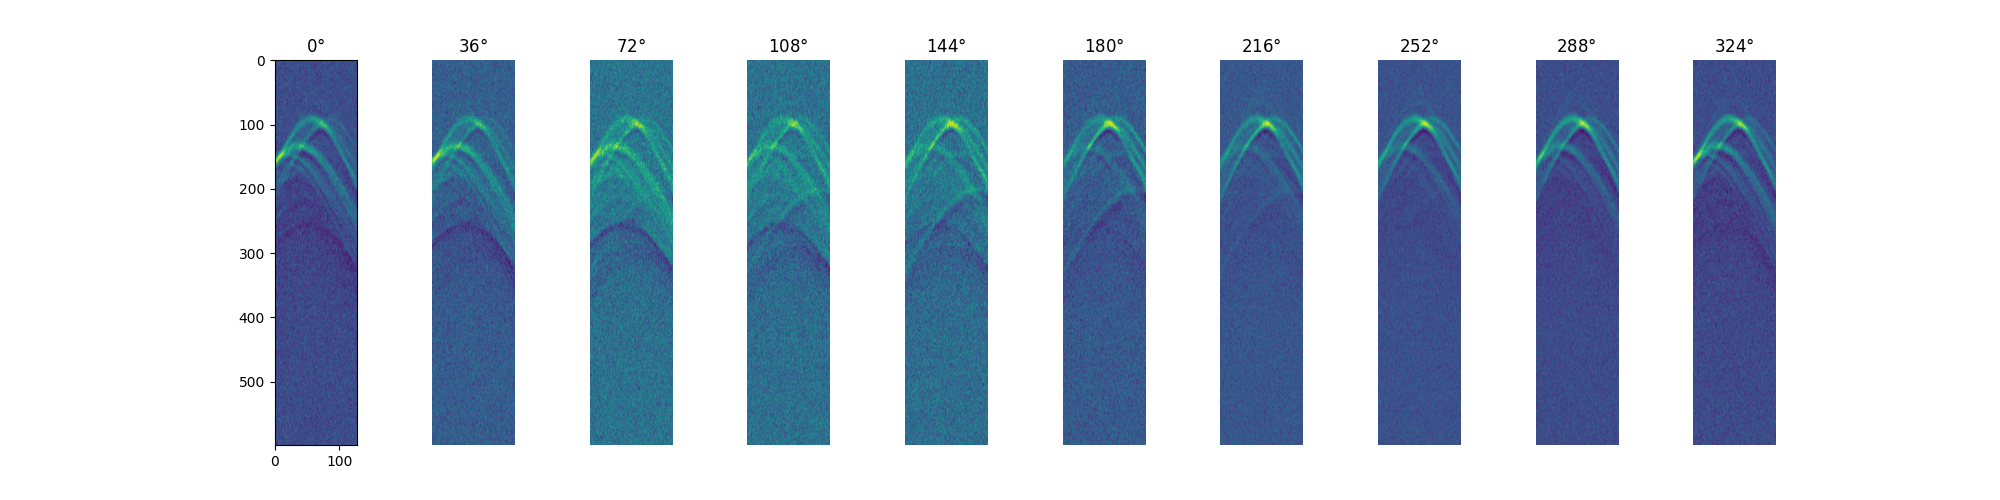

In [ ]:
fig, ax = plt.subplots(1, num, figsize=(num*2, 5))
for i in range(num):
    ax[i].imshow(P_data_noisy[i])
    ax[i].set_title(fr"{angles[i]:.0f}$\degree$")
    if i>0:
        ax[i].axis("off")
# plt.imshow(P_data[0])
# plt.savefig(save_path+"P_data.pdf", format="pdf", bbox_inches="tight")